In [1]:
import glob #to read the files
import json #to work if .json
import numpy as np #to math
import pandas as pd #to save the data
import math #to convertion calculus
from astropy.time import Time #to time converting
from astropy import units #time correction
from astropy.coordinates import SkyCoord #time correction
from scipy import interpolate #to interpolate the wavelength and flux
from tabulate import tabulate #to export in table format
from scipy.interpolate import interp1d
import scipy.optimize as opt

def radec_to_xyz(ra, dec):
    x = math.cos(np.deg2rad(dec)) * math.cos(np.deg2rad(ra))
    y = math.cos(np.deg2rad(dec)) * math.sin(np.deg2rad(ra))
    z = math.sin(np.deg2rad(dec))

    return np.array([x, y, z], dtype=np.float64)

#functions from sncosmo
def cmb_dz(ra, dec):
    """See http://arxiv.org/pdf/astro-ph/9609034
     CMBcoordsRA = 167.98750000 # J2000 Lineweaver
     CMBcoordsDEC = -7.22000000
    """

    # J2000 coords from NED
    CMB_DZ = 371000. / 299792458.
    CMB_RA = 168.01190437
    CMB_DEC = -6.98296811
    CMB_XYZ = radec_to_xyz(CMB_RA, CMB_DEC)

    coords_xyz = radec_to_xyz(ra, dec)
    
    dz = CMB_DZ * np.dot(CMB_XYZ, coords_xyz)

    return dz

def cmb_to_helio(z, ra, dec):
    """Convert from CMB-frame redshift to heliocentric redshift.
    
    Parameters
    ----------
    z : float
        CMB-frame redshift.
    ra, dec: float
        RA and Declination in degrees (J2000).
    """

    dz = -cmb_dz(ra, dec)
    one_plus_z_pec = math.sqrt((1. + dz) / (1. - dz))
    one_plus_z_helio = (1. + z) * one_plus_z_pec

    return one_plus_z_helio - 1.


In [2]:
file = open("training_names.txt")
lines = file.readlines()
file.close()

sn_names = []

for line in lines:
    if line.startswith('#'): continue
    co=line.rstrip().replace('INDEF','Nan').split()
    sn_names.append(co[0])

In [3]:
sn_names

['SN2005A.json',
 'iPTF13dge.json',
 'SN2002fk.json',
 'SN1997bp.json',
 'SN1998dk.json',
 'SN2005cf.json',
 'SN2013aj.json',
 'SN2011hr.json',
 'SN2010ae.json',
 'SN2007F.json',
 'SN2009aa.json',
 'SN2002bz.json',
 'SN1998dm.json',
 'SN2003du.json',
 'SN2006is.json',
 'SN2007if.json',
 'SN2008hv.json',
 'SN2007bm.json',
 'SN2004gs.json',
 'SN2012cg.json',
 'SN2001fe.json',
 'SN1998bu.json',
 'SN2001C.json',
 'SN2008fp.json',
 'SN2003it.json',
 'SN1999dq.json',
 'SN2006gr.json',
 'SN2001G.json',
 'SN2005hk.json',
 'SN2000cx.json',
 'SN2002jy.json',
 'SN2008ar.json',
 'SN2012ht.json',
 'SN2007A.json',
 'SN2007fb.json',
 'SN2006lf.json',
 'SN2003fd.json',
 'SN2002de.json',
 'SN2006N.json',
 'SN2007af.json',
 'SN2006hb.json',
 'SN1998dh.json',
 'SN1996X.json',
 'SN2007nq.json',
 'SN2003cg.json',
 'SN2007on.json',
 'SN2012fr.json',
 'SN1997br.json',
 'LSQ12gdj.json',
 'SN2005am.json',
 'SN1994ae.json',
 'SN2000fa.json',
 'SN2005kc.json',
 'SN2011fe.json',
 'SN2003kf.json',
 'SN2008C.json',

In [4]:
final_gradex = np.linspace(-21, 51, 70)
final_gradey = np.linspace(2001, 9201, 300)
final_flux = [[[] for x in range(0,len(final_gradey))] for y in range(0,len(final_gradex))] 
tolerance_x = 0.2
tolerance_y = 5
total_sn = 0
#print(final_gradex)
#print(final_gradey)
#names of .json in the folder
#names=glob.glob("*.json")
#for each sn
for u in range(0,len(sn_names)):
    print(sn_names[u])

    #reading the .json file
    with open(sn_names[u], "r") as read_file:
        data = json.load(read_file)

    #catching the name of supernova
    url=sn_names[u]
    if url.endswith('.json'):
        url = url[:-5]
    #print(url)
    #defining the lists
    wavelengthdat=[]
    fluxdat=[]
    timedat=[]

    #redshift correction

    #if there is 1 value use it
    if len(data[url]["redshift"]) == 1:

        #if there is kind in the list continue
        if "kind" in data[url]["redshift"][0]:

            #if its heliocentric pick then
            if data[url]["redshift"][0]["kind"] == "heliocentric":

                redshift = float(data[url]["redshift"][0]["value"])

            #if its cmb pick then    
            elif data[url]["redshift"][0]["kind"] == "cmb":

                #convertion of hours to degrees
                if data[url]["ra"][0]["u_value"] == "hours" and data[url]["dec"][0]["u_value"] == "degrees":

                    c = SkyCoord(str(data[url]["ra"][0]["value"]),str(data[url]["dec"][0]["value"]), unit=(units.hourangle, units.deg))

                elif data[url]["ra"][0]["u_value"] == "hours" and data[url]["dec"][0]["u_value"] == "hours":

                    c = SkyCoord(str(data[url]["ra"][0]["value"]),str(data[url]["dec"][0]["value"]), unit=(units.hourangle, units.hourangle))

                else:

                    print("Erro!")

                redshift = float(cmb_to_helio(float(data[url]["redshift"][0]["value"]), c.ra.deg, c.dec.deg))

        #if there is only 1 and its not specificated
        else:
            
            redshift = float(data[url]["redshift"][0]["value"])

    #print(redshift)

    #if not...
    else:

        sumredshift = 0
        nredshift = 0
        alert0 = 0
        alert0_test = 0
        while nredshift < len(data[url]["redshift"]):
            
            #if there is kind in the list continue
            if "kind" in data[url]["redshift"][nredshift]:

                #if its heliocentric pick then
                if data[url]["redshift"][nredshift]["kind"] == "heliocentric":

                    redshift = float(data[url]["redshift"][nredshift]["value"])
                    nredshift = len(data[url]["redshift"]) + 1
                    alert0 = 1
                #if its cmb    
                elif data[url]["redshift"][nredshift]["kind"] == "cmb" and alert0 == 0:

                    #convertion of hours to degrees
                    if data[url]["ra"][nredshift]["u_value"] == "hours" and data[url]["dec"][nredshift]["u_value"] == "degrees":

                        c = SkyCoord(str(data[url]["ra"][nredshift]["value"]),str(data[url]["dec"][nredshift]["value"]), unit=(units.hourangle, units.deg))

                    elif data[url]["ra"][nredshift]["u_value"] == "hours" and data[url]["dec"][nredshift]["u_value"] == "hours":

                        c = SkyCoord(str(data[url]["ra"][nredshift]["value"]),str(data[url]["dec"][nredshift]["value"]), unit=(units.hourangle, units.hourangle))

                    else:

                        print("Erro 1!")

                    #convertion of cmb to heliocentric
                    redshift = float(cmb_to_helio(float(data[url]["redshift"][nredshift]["value"]), c.ra.deg, c.dec.deg))
                    nredshift = len(data[url]["redshift"]) + 1
                    alert0 = 1
            
            
            #if not realize a sum to obtain a mean value
            elif "kind" not in data[url]["redshift"][nredshift] and alert0 == 0:
                sumredshift = sumredshift + float(data[url]["redshift"][nredshift]["value"])
                
                #if the sn is in the hubnle flow realize a mean value of the redshifts
                if float(data[url]["redshift"][nredshift]["value"]) > 0.15:
                
                    alert0_test = 1
                
                #if not the first redshift is the max redshift
                if nredshift == 0:
                    print(nredshift)
                    maxredshift = float(data[url]["redshift"][nredshift]["value"])
                
                else:
                    #then analise if the next redshift is grater than max redshift 
                    if float(data[url]["redshift"][nredshift]["value"]) > maxredshift:
                        
                        maxredshift = float(data[url]["redshift"][nredshift]["value"])
                
                #print("nenhum especificado")
                
            nredshift = nredshift + 1
        
        if alert0 == 0 and alert0_test == 1:
            
            #if sne is in the hubble flow realize a mean value
            redshift = sumredshift/len(data[url]["redshift"])
            
        elif alert0 == 0 and alert0_test == 0:
            
            #if not the maximum redshift is the heliocentric redshift
            redshift = maxredshift
        
    #print(redshift)

    #time correction to julian date
    t0dat = data[url]["maxdate"][0]["value"]
    t0 = t0dat.split("/")
    t0=str(t0[0])+'-'+str(t0[1])+'-'+str(t0[2])
    t0=Time(t0).mjd
    
    #spectra data
    i=0
    n=0
    times = []
    max_fluxes = []
    spectra_number = 0
    time_verification = 0
    wavelength_verification = 0
    while i < len(data[url]["spectra"]):
        
 
        
    
        spectratime = float(data[url]["spectra"][i]["time"]) - float(t0)
        #print(spectratime)
        #verifing if its calibrated and if it have a redshift correction 
        alert1 = 0 #for calibration
        alert2 = 0 #for redshift correction

        if data[url]["spectra"][i]["u_fluxes"] == "erg/s/cm^2/Angstrom":          
            alert1 = 1 #first alert

            if "deredshifted" in data[url]["spectra"][i]:
                alert2 = 1 #second alert

        #if its calibrated and corrected
        if alert1 == 1 and alert2 == 1:

            #there are 3 collumns: wavelength flux and flux error
            if len(data[url]["spectra"][i]["data"][0]) == 3:

                df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux', 'fluxerror'])

                #sort the data by wavelength
                df.sort_values(by=['wavelength'])

                #converting to float
                df['wavelength'] = df['wavelength'].astype(float)
                df['flux'] = df['flux'].astype(float)

                #to kill negative fluxes
                fluxtemp = []
                for var in range(0,len(df['flux'])):
                    if (df['flux'][var] > 0):
                        fluxtemp.append(df['flux'][var])
                    else:
                        fluxtemp.append(0)            

                '''        
                max_flux = max(fluxtemp)
                max_flux_pos = [i for i, j in enumerate(fluxtemp) if j == max_flux]
                if max_flux_pos[0] != 1 and max_flux_pos[0] != 2:
                    max_wavelength = df['wavelength'][max_flux_pos[0]]
                    if 3800 < max_wavelength < 4200:

                        wavelength_verification = 1
                        max_fluxes.append(max_flux)
                        times.append(spectratime) 
                
                
                if min_value_wavelength < 4000 < max_value_wavelength:
                    f = interp1d(df['wavelength'], fluxtemp, kind='linear')
                    if max(fluxtemp) != fluxtemp[0] and max(fluxtemp) != fluxtemp[-1]:
                        ab = opt.fmin(lambda x: -f(x), 4000, disp=False)
                    
                    if 3800 < ab[0] < 4200: 
                        
                        wavelength_verification = 1
                        max_flux.append(f(ab[0]))
                        times.append(spectratime)
                '''                
                spectra_number = spectra_number + 1    
                #making a list of lists 
                wavelengthdat.append(np.array(df['wavelength']))
                fluxdat.append(np.array(fluxtemp))

                #for time
                timedat.append(spectratime)

            #there are 2 collumns: wavelength and flux
            elif len(data[url]["spectra"][i]["data"][0]) == 2:

                df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux'])

                #sort the data by wavelength
                df.sort_values(by=['wavelength'])

                #converting to float
                df['wavelength'] = df['wavelength'].astype(float)
                df['flux'] = df['flux'].astype(float)

                #to kill negative fluxes
                fluxtemp = []
                for var in range(0,len(df['flux'])):
                    if (df['flux'][var] > 0):
                        fluxtemp.append(df['flux'][var])
                    else:
                        fluxtemp.append(0)            

                '''        
                max_flux = max(fluxtemp)
                max_flux_pos = [i for i, j in enumerate(fluxtemp) if j == max_flux]
                if max_flux_pos[0] != 1 and max_flux_pos[0] != 2:
                    max_wavelength = df['wavelength'][max_flux_pos[0]]
                    if 3800 < max_wavelength < 4200:

                        wavelength_verification = 1
                        max_fluxes.append(max_flux)
                        times.append(spectratime) 
                
                
                if min_value_wavelength < 4000 < max_value_wavelength:
                    f = interp1d(df['wavelength'], fluxtemp, kind='linear')
                    if max(fluxtemp) != fluxtemp[0] and max(fluxtemp) != fluxtemp[-1]:
                        ab = opt.fmin(lambda x: -f(x), 4000, disp=False)
                    
                    if 3800 < ab[0] < 4200: 
                        
                        wavelength_verification = 1
                        max_flux.append(f(ab[0]))
                        times.append(spectratime)
                '''                
                spectra_number = spectra_number + 1    
                #making a list of lists 
                wavelengthdat.append(np.array(df['wavelength']))
                fluxdat.append(np.array(fluxtemp))

                #for time
                timedat.append(spectratime)


        #if its calibrated, redshift not adjusted but with a clear redshift
        elif alert1 ==1 and alert2 == 0:   

            #there are 3 collumns: wavelength flux and flux error 
            if len(data[url]["spectra"][i]["data"][0]) == 3:

                df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux', 'fluxerror'])

                #sort the data by wavelength
                df.sort_values(by=['wavelength'])

                #converting to float
                df['wavelength'] = df['wavelength'].astype(float)
                df['flux'] = df['flux'].astype(float)

                #to kill negative fluxes
                fluxtemp = []
                for var in range(0,len(df['flux'])):
                    if (df['flux'][var] > 0):
                        fluxtemp.append(df['flux'][var])
                    else:
                        fluxtemp.append(0)

                        
                #redshift correction
                fluxtemp = [x * (((1+redshift))**3) for x in fluxtemp] #for the flux           
                df['wavelength'] = [x * (1/(1+redshift)) for x in df['wavelength']] #for the wavelength
                spectratime = spectratime/(1+redshift) #for time
                
                '''
                max_flux = max(fluxtemp)
                max_flux_pos = [i for i, j in enumerate(fluxtemp) if j == max_flux]
                if max_flux_pos[0] != 1 and max_flux_pos[0] != 2:
                    max_wavelength = df['wavelength'][max_flux_pos[0]]
                    if 3800 < max_wavelength < 4200:

                        wavelength_verification = 1
                        max_fluxes.append(max_flux)
                        times.append(spectratime) 
                
                
                if min_value_wavelength < 4000 < max_value_wavelength:
                    f = interp1d(df['wavelength'], fluxtemp, kind='linear')
                    if max(fluxtemp) != fluxtemp[0] and max(fluxtemp) != fluxtemp[-1]:
                        ab = opt.fmin(lambda x: -f(x), 4000, disp=False)
                    
                    if 3800 < ab[0] < 4200: 
                        
                        wavelength_verification = 1
                        max_flux.append(f(ab[0]))
                        times.append(spectratime)
                '''                
                spectra_number = spectra_number + 1    
                #making a list of lists 
                wavelengthdat.append(np.array(df['wavelength']))
                fluxdat.append(np.array(fluxtemp))

                #for time
                timedat.append(spectratime)

            #there are 2 collumns: wavelength flux and flux error 
            elif len(data[url]["spectra"][i]["data"][0]) == 2:

                df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux'])

                #sort the data by wavelength
                df.sort_values(by=['wavelength'])

                #converting to float
                df['wavelength'] = df['wavelength'].astype(float)
                df['flux'] = df['flux'].astype(float)

                #to kill negative fluxes
                fluxtemp = []
                for var in range(0,len(df['flux'])):
                    if (df['flux'][var] > 0):
                        fluxtemp.append(df['flux'][var])
                    else:
                        fluxtemp.append(0)

                #redshift correction
                fluxtemp = [x * (((1+redshift))**3) for x in fluxtemp] #for the flux           
                df['wavelength'] = [x * (1/(1+redshift)) for x in df['wavelength']] #for the wavelength
                spectratime = spectratime/(1+redshift) #for time

                '''        
                max_flux = max(fluxtemp)
                max_flux_pos = [i for i, j in enumerate(fluxtemp) if j == max_flux]
                if max_flux_pos[0] != 1 and max_flux_pos[0] != 2:
                    max_wavelength = df['wavelength'][max_flux_pos[0]]
                    if 3800 < max_wavelength < 4200:

                        wavelength_verification = 1
                        max_fluxes.append(max_flux)
                        times.append(spectratime) 
                
                
                if min_value_wavelength < 4000 < max_value_wavelength:
                    f = interp1d(df['wavelength'], fluxtemp, kind='linear')
                    if max(fluxtemp) != fluxtemp[0] and max(fluxtemp) != fluxtemp[-1]:
                        ab = opt.fmin(lambda x: -f(x), 4000, disp=False)
                    
                    if 3800 < ab[0] < 4200: 
                        
                        wavelength_verification = 1
                        max_flux.append(f(ab[0]))
                        times.append(spectratime)
                '''                
                spectra_number = spectra_number + 1    
                #making a list of lists 
                wavelengthdat.append(np.array(df['wavelength']))
                fluxdat.append(np.array(fluxtemp))

                #for time
                timedat.append(spectratime)
                
        i = i + 1
    
    final_wavelengthdat = []
    final_fluxdat = []
    final_timedat = []
    '''
    table = []
    for k in range(0,len(timedat)):
        for l in range(0, len(wavelengthdat)):
            table.append((timedat[k], wavelengthdat[k][l], fluxdat[k][l]))

    f = open(url+".dat", 'w')
    f.write(tabulate(table, tablefmt="plain"))
    f.close()
    '''
    #if wavelength_verification == 1:
    #if min(times) > -10 and max(times) < 10:
    final_wavelengthdat = wavelengthdat
    final_fluxdat = fluxdat
    final_timedat = timedat
    total_sn = total_sn + 1   
        #print(":)")
    
    #else:
        #print(":(")
    
    print(spectra_number)
    
    for m in range(0,len(final_gradex)):

        for n in range(0,len(final_gradey)):

            for i in range(0,len(final_timedat)):
                if (final_gradex[m] - tolerance_x) < final_timedat[i] < (final_gradex[m] + tolerance_x):

                    for j in range(0,len(final_wavelengthdat[i])):

                        if (final_gradey[n] - tolerance_y) < final_wavelengthdat[i][j] < (final_gradey[n] + tolerance_y):
                            final_flux[m][n].append(final_fluxdat[i][j])        
                            #print(final_gradex[m], final_gradey[n])
                               
print(total_sn)

SN2005A.json
12
iPTF13dge.json
19
SN2002fk.json
24
SN1997bp.json
13
SN1998dk.json
10
SN2005cf.json
36
SN2013aj.json
11
SN2011hr.json
12
SN2010ae.json
22
SN2007F.json
13
SN2009aa.json
16
SN2002bz.json
10
SN1998dm.json
10
SN2003du.json
23
SN2006is.json
19
SN2007if.json
31
SN2008hv.json
14
SN2007bm.json
13
SN2004gs.json
12
SN2012cg.json
10
SN2001fe.json
12
SN1998bu.json
33
SN2001C.json
13
SN2008fp.json
19
SN2003it.json
15
SN1999dq.json
23
SN2006gr.json
17
SN2001G.json
16
SN2005hk.json
13
SN2000cx.json
18
SN2002jy.json
11
SN2008ar.json
32
SN2012ht.json
26
SN2007A.json
10
SN2007fb.json
11
SN2006lf.json
20
SN2003fd.json
10
SN2002de.json
11
SN2006N.json
12
SN2007af.json
44
SN2006hb.json
22
SN1998dh.json
10
SN1996X.json
0
15
SN2007nq.json
16
SN2003cg.json
18
SN2007on.json
28
SN2012fr.json
137
SN1997br.json
11
LSQ12gdj.json
38
SN2005am.json
26
SN1994ae.json
18
SN2000fa.json
15
SN2005kc.json
10
SN2011fe.json
67
SN2003kf.json
26
SN2008C.json
22
SN2007co.json
17
SN2007bc.json
11
SN2008ia.json
11
S

In [22]:
mean_flux = []
xx_test = []
yy_test = []

In [23]:
for m in range(0,len(final_gradex)):
    for n in range(0,len(final_gradey)):
        
        if len(final_flux[m][n]) > 10:
            mean_value = np.mean(final_flux[m][n])
            std_value = np.std(final_flux[m][n])
            
            s = 0
            lenght = 0
            for i in range(0, len(final_flux[m][n])):
                
                if abs(final_flux[m][n][i] - mean_value) < std_value/5:
                    
                    s = s + final_flux[m][n][i]
                    lenght = lenght + 1
                    
            if lenght != 0:
                
                mean_flux.append(s/lenght)
                xx_test.append(final_gradex[m])
                yy_test.append(final_gradey[n])
            

In [24]:
mean_flux[len(mean_flux)-1]

9.153902127327493e-16

<IPython.core.display.Javascript object>


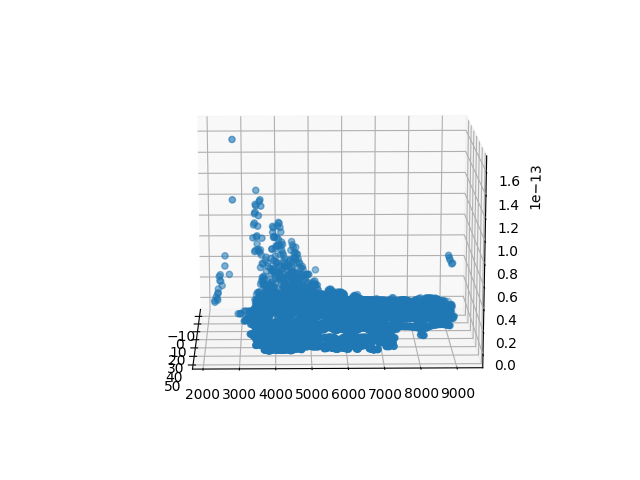

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx_test, yy_test, mean_flux)
#ax.set_zlim3d(0,1)
plt.show()

In [9]:
table = []
for k in range(0,len(xx_test)):
    table.append((xx_test[k], yy_test[k], mean_flux[k]))

f = open("M0.dat", 'w')
f.write(tabulate(table, tablefmt="plain"))
f.close()

In [10]:
import scipy as sp
import scipy.interpolate
spline = sp.interpolate.Rbf(xx_test,yy_test,mean_flux,function='linear')

KeyboardInterrupt: 

In [26]:
x_grid = np.linspace(-10, 50, 50)
y_grid = np.linspace(3500,9000, 50)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')

<IPython.core.display.Javascript object>


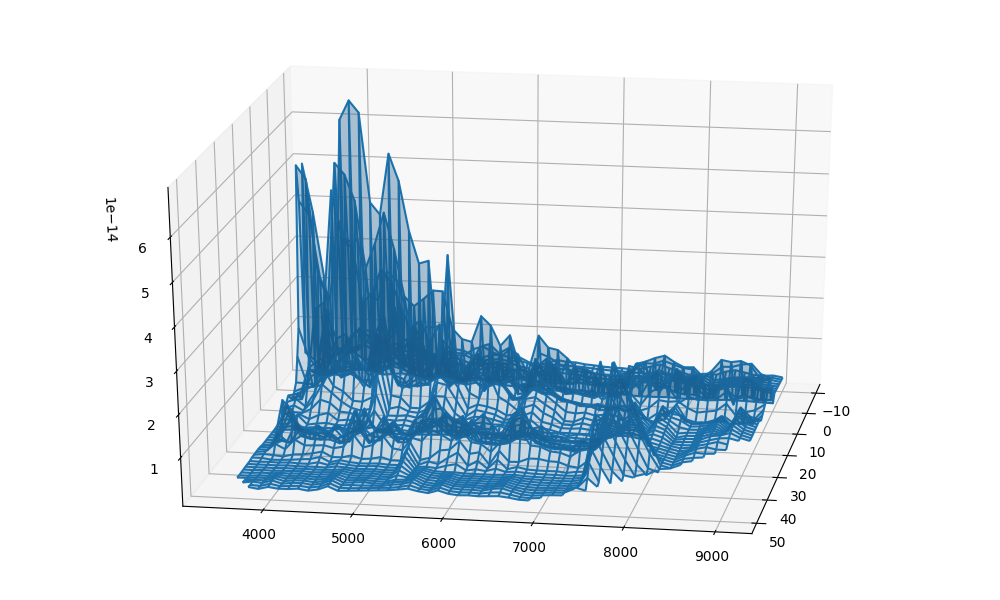

/home/joao/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  


In [27]:
from mpl_toolkits.mplot3d import axes3d
import scipy.interpolate as interp
Z = interp.griddata((xx_test,yy_test),mean_flux,(B1,B2),method='linear')
%matplotlib notebook
fig = plt.figure(figsize=(10,6))
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z)
ax.plot_surface(B1, B2, Z,alpha=0.2)
#ax.scatter3D(xx_test,yy_test,mean_flux, c='r')

plt.show()